In [1]:
import numpy as np
import pandas as pd
import math
import time

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
# Import Data
assets = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'LUNAUSDT', 'SOLUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 'DOGEUSDT', '1000SHIBUSDT', 'MATICUSDT', 'ATOMUSDT', 'LTCUSDT', 'NEARUSDT', 'TRXUSDT', 'LINKUSDT', 'BCHUSDT', 'ALGOUSDT', 'XLMUSDT', 'UNIUSDT', 'AXSUSDT', 'MANAUSDT', 'ETCUSDT', 'XMRUSDT', 'EGLDUSDT', 'SANDUSDT', 'FILUSDT', 'FTMUSDT', 'EOSUSDT', 'ZECUSDT', 'AAVEUSDT', 'COMPUSDT', 'MKRUSDT', 'YFIUSDT', 'YFIIUSDT']
data = {}
prices = {}
timeframe = '1h'

if timeframe == '1h':
    filename = './{}_1h.csv'
elif timeframe == '15m':
    filename = './{}_15m.csv'
elif timeframe == '5m':
    filename = './{}_5m.csv'

for asset in assets:
    data[asset] = pd.read_csv(filename.format(asset), index_col=0)
    data[asset].iloc[:,0] = pd.to_datetime(data[asset].iloc[:,0], unit='ms')
    prices[asset] = pd.DataFrame({'date': data[asset].iloc[:,0], 'price': data[asset].iloc[:,3]})
    prices[asset]['log_price'] = prices[asset]['price'].apply(lambda x: math.log(x))


### Functions

In [21]:
def set_same_length(df1, df2):
    # Set data same length
    if len(df1) > len(df2):
        diff = len(df1) - len(df2)
        df1 = df1[diff:]
    elif len(df1) < len(df2):
        diff = len(df2) - len(df1)
        df2 = df2[diff:]
    else:
        pass
    
    return df1, df2


def rolling_zscore(series, window):
    mean = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()

    return (series - mean) / std


def get_backtest_performance(price_a, price_b, positions, fees, starting_capital, beta):
    
    returns_a = price_a.pct_change().fillna(0) #* beta #todo: make sure beta goes there
    returns_b = price_b.pct_change().fillna(0) #* beta #todo: make sure beta goes there
    
     # Calculate Fees
    trades = 0
    current_pos = 0
    for i in positions:
        if i != current_pos:
            trades += 1
            current_pos = i
            
    fees_paid = 1 - (1-fees)**trades
    
    # Calculate strategy return
    long_leg_returns = pd.Series(list(returns_a)) * pd.Series(positions) # Returns of first leg
    short_leg_returns = pd.Series(list(returns_b)) * pd.Series(positions) * -1 #Returns of second leg (must inverse positions first)

    long_leg_cumsum = long_leg_returns.cumsum().apply(np.exp)
    long_leg_max_dd = long_leg_returns.cumsum().apply(np.exp)
    short_leg_cumsum = short_leg_returns.cumsum().apply(np.exp)

    long_leg_dollar_size = starting_capital / 2 #* beta
    short_leg_dollar_size = starting_capital - long_leg_dollar_size
    
    long_leg_dollar_returns = long_leg_dollar_size * list(long_leg_cumsum)[len(long_leg_cumsum)-1]
    short_leg_dollar_returns = short_leg_dollar_size * list(short_leg_cumsum)[len(short_leg_cumsum)-1]
    
    capital = long_leg_dollar_size * long_leg_cumsum + short_leg_dollar_size * short_leg_cumsum

    return capital, fees_paid, trades


## Returns backtesting stats from strategy
# price_a: series
# prices_b: series
# window: rolling window for zscore
# std_multiple: nbr of standard deviation where we want to trigger trades
# trading_fee: fee in %
# capital: starting capital in $
# beta: price_b is the dependant variable (Y), so Y = beta * X. We multiply beta with dollar size for price_a
def zscore_mean_reversion_strategy(price_a, price_b, window, std_multiple, trading_fee, starting_capital, beta):
    
    returns_a = price_a.pct_change().fillna(0)
    returns_b = price_b.pct_change().fillna(0)
    positions = [0,0]
    
    spread = price_a / price_b
    zscore = list(rolling_zscore(spread, window).fillna(0))
    
    # Get Trades
    for i in range(2, len(zscore)):
        # If short and zscore goes at or under 0, close short
        if positions[i-1] == -1 and zscore[i-1] <= 0:
            positions.append(0)
        # If long and zscore goes at or above 0, close long
        elif positions[i-1] == 1 and zscore[i-1] >= 0:
            positions.append(0)
        # If zscore goes above std and comes back under, short signal
        elif positions[i-1] == 0 and zscore[i-2] > std_multiple and zscore[i-1] < std_multiple:
            positions.append(-1)
        # If zscore goes under std and comes back over, long signal
        elif positions[i-1] == 0 and zscore[i-2] < -std_multiple and zscore[i-1] > -std_multiple:
            positions.append(1)
        # Else, keep same position
        else:
            positions.append(positions[i-1])
    
    capital, fees_paid, nbr_of_trades = get_backtest_performance(price_a, price_b, positions, trading_fee, starting_capital, beta)

    return positions, capital, fees_paid, nbr_of_trades, zscore


##
# params: {asset_a, asset_b, starting_capital, fees, rolling_window, std_entry, beta, start_date, end_date}
# visualize: show plots
# returns: strategy returns, fees paid, max drawdown
def backtest_zscore_strategy(params, visualize=True):
    asset_a = params['asset_a']
    asset_b = params['asset_b']
    start_capital = params['starting_capital']
    fees = params['fees']
    rolling_window = params['rolling_window']
    std_entry = params['std_entry']
    beta = params['beta']
    start_date = params['start_date']
    end_date = params['end_date']

    data_a = prices[asset_a][prices[asset_a]['date'] > start_date]
    data_a = data_a[data_a['date'] < end_date]
    data_b = prices[asset_b][prices[asset_b]['date'] > start_date]
    data_b = data_b[data_b['date'] < end_date]
    data_a, data_b = set_same_length(data_a, data_b)
    dates = data_a['date']
    price_a = data_a.reset_index()['price']
    price_b = data_b.reset_index()['price']
    spread = price_a/price_b

    positions, capital, fees_paid, nbr_of_trades, zscore = zscore_mean_reversion_strategy(price_a, price_b, rolling_window, std_entry, fees, start_capital, beta)

    # Max drawdown calculation
    dd_i = np.argmax(np.maximum.accumulate(capital) - capital) # end of the period
    if dd_i > 0:
        dd_j = np.argmax(capital[:dd_i]) # start of period
        max_dd = (capital[dd_i]-capital[dd_j])/capital[dd_i]
    else:
        max_dd = 0

    # Visualization
    if visualize:
        fig, axs = plt.subplots(3, figsize=(20,15))
        fig.figsize=(20,15)
        axs[0].plot(dates, spread)
        axs[0].title.set_text('{}/{} Spread'.format(asset_a,asset_b))
        axs0_2 = axs[0].twinx()
        axs0_2.plot(dates, positions, color='b')
        axs[1].plot(dates, zscore)
        axs[1].title.set_text('Z-Score')
        axs[1].axhline(std_entry, color='r')
        axs[1].axhline(-std_entry, color='g')
        axs[1].axhline(0, color='b')
        axs[2].plot(dates, capital)
        axs[2].title.set_text('Performance')
    
    strategy_returns = (list(capital)[-1]/list(capital)[0]-1)*(1-fees_paid)
    
    return strategy_returns, fees_paid, nbr_of_trades, max_dd



### Backtest Single Pair

Returns: 273.74%
Number of trades: 526.00
Fees paid: 46.81%
Max Drawdown: -23.13%


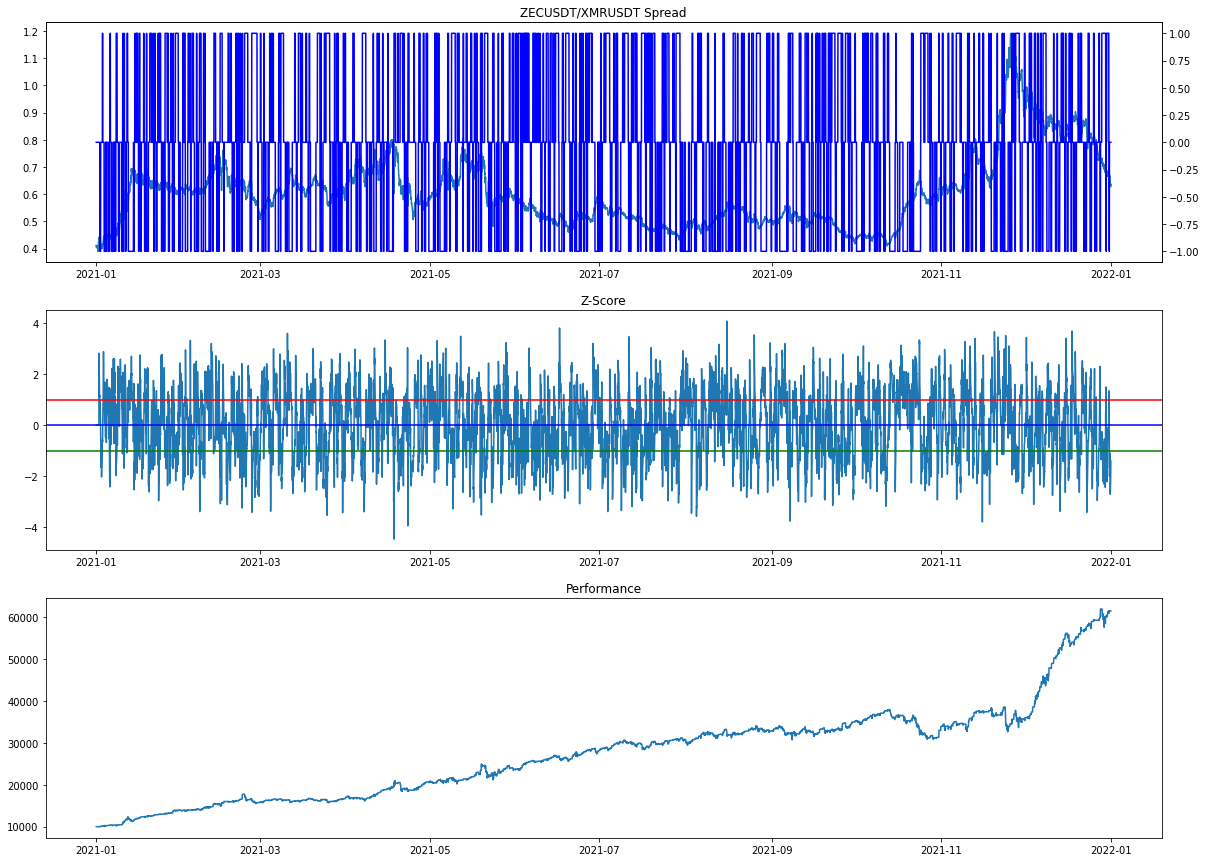

In [86]:
params = {
    'asset_a': 'ZECUSDT',
    'asset_b': 'XMRUSDT',
    'starting_capital': 10000.0,
    'fees': 0.0006,
    'rolling_window': 24,
    'std_entry': 1,
    'beta': 1,
    'start_date': '2021-01-01 00:00:00',
    'end_date': '2022-01-01 00:00:00'
}

returns, fees_paid, nbr_of_trades, max_drawdown = backtest_zscore_strategy(params, True)

print('Returns: {:.2f}%'.format(returns*100))
print('Number of trades: {:.2f}'.format(nbr_of_trades/2))
print('Fees paid: {:.2f}%'.format(fees_paid*100))
print('Max Drawdown: {:.2f}%'.format(max_drawdown*100))


### Rolling Window Optimization: Backtest vs Forwardtest

In [99]:
backtest_rolling_windows = range(24*1,24*30,12)
backtest_std_entry = np.arange(1,3,0.5)
forwardtest_rolling_windows = range(24*11,24*30)
backtest_returns_per_drawdown = pd.DataFrame(index=backtest_rolling_windows, columns=backtest_std_entry)

pairs = ['ZECUSDT/XMRUSDT', 'BTCUSDT/ETHUSDT', 'SANDUSDT/AXSUSDT', 'LTCUSDT/ETCUSDT', 'BCHUSDT/ETHUSDT']

for window in backtest_rolling_windows:
    for std_entry in backtest_std_entry:
        all_returns_per_drawdown = []
        for pair in pairs:
            asset_a, asset_b = pair.split('/')
            params = {
                'asset_a': asset_a,
                'asset_b': asset_b,
                'starting_capital': 10000.0,
                'fees': 0.0006,
                'rolling_window': window,
                'std_entry': std_entry,
                'beta': 1,
                'start_date': '2021-01-01 00:00:00',
                'end_date': '2022-01-01 00:00:00'
            }
            
            pair_returns, fees_paid, nbr_of_trades, max_drawdown = backtest_zscore_strategy(params, False)
            all_returns_per_drawdown.append(pair_returns/abs(max_drawdown))
            
        backtest_returns_per_drawdown.loc[window][std_entry] = np.median(all_returns_per_drawdown)



[Text(0.5, 69.0, 'STD Entry'), Text(114.0, 0.5, 'Rolling Window')]

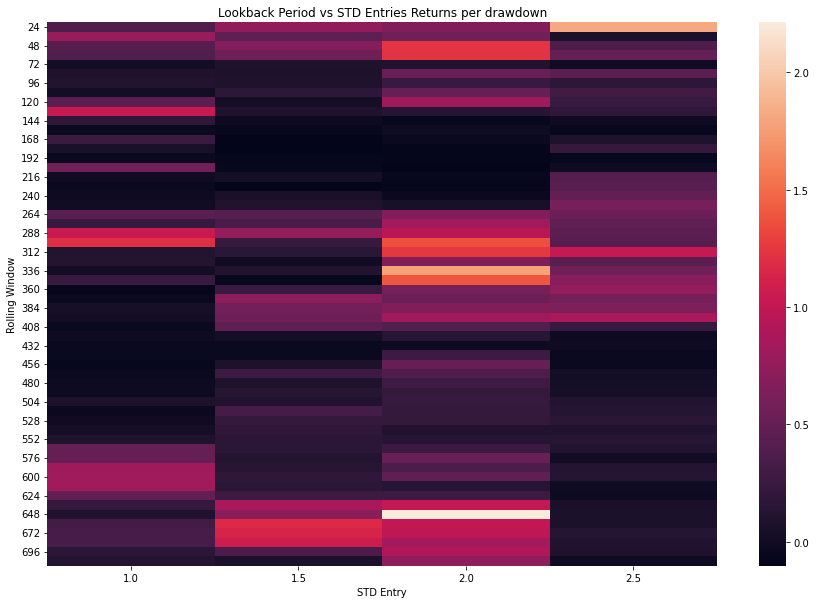

In [100]:
plt.figure(figsize=(15,10))
plt.title('Lookback Period vs STD Entries Returns per drawdown')
hm = sb.heatmap(backtest_returns_per_drawdown.astype(float))
hm.set(xlabel='STD Entry', ylabel='Rolling Window')


### STD Entry Optimization: Backtest vs Forwardtest